# Result parser

In [1]:
from collections import defaultdict

index_cols = defaultdict(int)
index_cols.update({
    "r-gitto-rank":1,
    'r-gitto-sirank':1,
    'somde':3,
})

p_use_columns = {
    "geary":"pval_norm_fdr_bh",
    "moran":"pval_norm_fdr_bh",
    "r-gitto-rank":"adj.p.value",
    "r-sparkx":"adjustedPval",
    'somde':'qval',
    'spanve-d':'fdrs',
    'spanve-k':'fdrs'
}
score_use_columns = {
    'r-gitto-sirank':'scores',
    'sepal':'average',

}

import os
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as chscore
from sklearn.metrics import davies_bouldin_score as dbscore
from sklearn.metrics import silhouette_score as siscore



result_dir = "./recode/SpatialLIBD/"
data_ids = os.listdir(result_dir)

def parse_file(data_dir,soft):
    path = os.path.join(result_dir,data_dir,soft)
    file = [i for i in os.listdir(path) if i.endswith('csv')][0]
    file = os.path.join(path,file)
    if soft not in p_use_columns:
        use_col = score_use_columns[soft]
    else:
        use_col = p_use_columns[soft]
    
    df = pd.read_csv(file,index_col=index_cols[soft]).filter(like=use_col)
    df.columns = [soft]
    return df

def evaluate_genesets(adata,genes,decomp=True,cluster_methods='kmeans'):
    ground = adata.obs['ground_truth']
    n = ground.unique().size
    temp_data = adata[:,genes]
    if decomp:
        sc.pp.pca(temp_data)
    if cluster_methods=='leiden':
        sc.pp.neighbors(temp_data, n_neighbors=20,random_state=0)
        sc.tl.umap(temp_data)
        sc.tl.leiden(temp_data)
        label = temp_data.obs['leiden'].values

    elif cluster_methods == 'kmeans':
        cluster = KMeans(n_clusters=n)
        label = cluster.fit_predict(temp_data.X)

    score1 = ari(ground.values,label)
    score2 = ami(ground.values,label)
    
    return score1,score2

def evaluate_genesets_ch(adata,genes):
    ground = adata.obs['ground_truth']
 
    temp_data = adata[:,genes].X
    
    score1 = chscore(temp_data,ground.values)
    score2 = dbscore(temp_data,ground.values) #dfmoranI[genes].mean()
    
    return score1,score2

In [2]:
from tqdm import tqdm

df_metrics = pd.DataFrame(columns=['soft','data','n_sig','s1','s2'])

for data_id in data_ids:
    adata = sc.read_h5ad(f'./data/SpatialLIBD/{data_id}')

    sc.pp.normalize_total(
        adata,
        target_sum=1e6
    )
    sc.pp.log1p(adata)
    adata.X = (adata.X - adata.X.mean(0)) / adata.X.std(0)

    softs = ['spanve-k','spanve-d','somde','moran','geary','r-sparkx','r-gitto-rank','sepal','r-gitto-sirank']
    df_datares = pd.concat(
        [parse_file(data_id,soft) for soft in softs],
        axis=1
    )
    #dfmoranI = pd.read_csv(f'./recode/SpatialLIBD/{data_id}/moran/moranI.test.csv',index_col=0).iloc[:,0]

    for soft in (softs+['spatialde']):
        if soft in p_use_columns:
            genes = df_datares.index[df_datares[soft]<0.05]
            if len(genes) > 1000:
                genes = df_datares[soft].sort_values().index[0:1000]
            s1,s2 = evaluate_genesets_ch(adata,genes)
            df_metrics.loc[len(df_metrics),:] = soft,data_id,genes.size,s1,s2
        elif soft in score_use_columns:
            genes = df_datares[soft].sort_values(ascending=False).index[0:1000]
            s1,s2 = evaluate_genesets_ch(adata,genes)
            df_metrics.loc[len(df_metrics),:] = soft,data_id,genes.size,s1,s2
        else:
            assert soft=='spatialde'
            genes = pd.read_csv(f"./data/SpatialLIBD/HumaPilot/SpatialDE_filtered_sample_{data_id.replace('.h5ad','.csv')}",index_col=0).index
            s1,s2 = evaluate_genesets_ch(adata,genes)
            df_metrics.loc[len(df_metrics),:] = soft,data_id,genes.size,s1,s2

In [3]:
df_metrics['soft'] = df_metrics['soft'].map(
    {
        'spanve-k':'Spanve-k',
        'spanve-d':'Spanve-d',
        'somde':'SOMDE',
        'moran':'Moran test',
        'geary':'Geary test',
        'r-sparkx':'SPARK-X',
        'r-gitto-rank':'Gitto-Rank',
        'sepal':'sepal*',
        'r-gitto-sirank':'Gitto-siRank*',
        'spatialde':'SpatialDE'
    }
)

/tmp/ipykernel_19695/1156804393.py:12: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes[0].get_shared_x_axes().join(axes[0],axes[1])


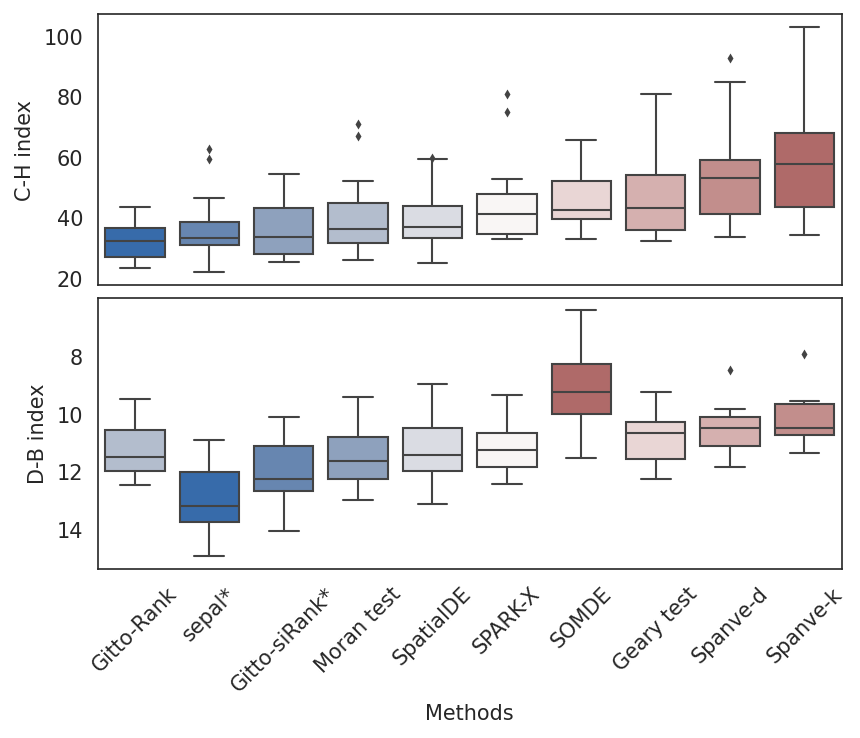

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

color_map = sns.color_palette('vlag',as_cmap=True)
saturation=0.75
order = df_metrics.groupby('soft')['s1'].median().sort_values().index

sns.set_style(style='white')
f,axes = plt.subplots(2,1,dpi=150)

f.subplots_adjust(hspace=0.05)
axes[0].get_shared_x_axes().join(axes[0],axes[1])

plot_metric = 's1'

sns.boxplot(
    x='soft',y=plot_metric,
    data=df_metrics,
    order=order,
    ax =axes[0],linewidth=1,fliersize=2,saturation=saturation,
    palette={
        soft:color_map(i/len(order))
        for i,soft in enumerate(df_metrics.groupby('soft')[plot_metric].median().sort_values().index)
    }
)
axes[0].set_xticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('C-H index')
# axes[0].set_yticks([])

plot_metric = 's2'
sns.boxplot(
    x='soft',y=plot_metric,
    data=df_metrics,
    order=order,
    ax =axes[1], linewidth=1,fliersize=2,saturation=saturation,
    palette= {
        soft:color_map(i/len(order))
        for i,soft in enumerate(df_metrics.groupby('soft')[plot_metric].median().sort_values(ascending=False).index)
    }
)
_ = axes[1].set_xticklabels([i.replace('r-','') for i in order], rotation=45) 
axes[1].set_xlabel('Methods')
axes[1].set_ylabel('D-B index')
axes[1].invert_yaxis()
_=axes[1].set_yticks([8,10,12,14])
f.savefig('./Results/metrics_SpatialLIBD.pdf',bbox_inches='tight')

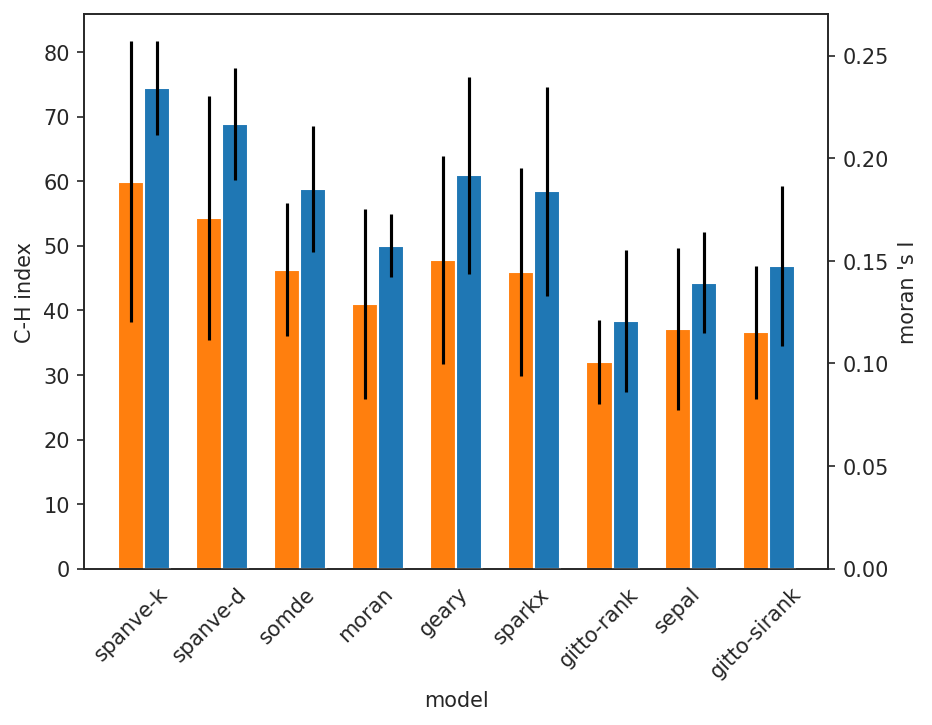

In [80]:
def draw_merged_bar_plot(df,score1,score2,ax,barWidth=0.5):
    all_cat = df.index.unique()
    r1 = np.arange(len(all_cat))*1.5
    r2 = [x + barWidth for x in r1]
    
    bars1 = [df.loc[cat,score1].mean() for cat in all_cat]
    yer1 = [df.loc[cat,score1].std() for cat in all_cat]
    ax.bar(
        r1, bars1, 
        width = barWidth,yerr=yer1, color = '#ff7f0e', 
        # edgecolor = 'black', capsize=7,
        label='s1'
    )
    
    ax2 = ax.twinx()
    bars2 = [df.loc[cat,score2].mean() for cat in all_cat]
    yer2 = [df.loc[cat,score2].std() for cat in all_cat]
    ax2.bar(
        r2, bars2, width = barWidth, yerr=yer2,
        color = '#1f77b4', 
        # edgecolor = 'black', capsize=7,
        label='s2')
    # Custom X axis
    # ax.set_xticks([r + barWidth for r in range(len(df))])
    # ax.legend()
    ax.set_xlabel("model")
    ax.set_xticks([r*1.5-0.5 + barWidth for r in range(len(all_cat))])
    ax.set_xticklabels([i.replace('r-','') for i in all_cat],rotation=45)
    ax.set_ylabel('C-H index')
    ax2.set_ylabel('moran\'s I')

sns.set_style(style='white')
f,ax =plt.subplots(1,1,dpi=150)
draw_merged_bar_plot(df_metrics.set_index('soft'),'s1','s2',ax)


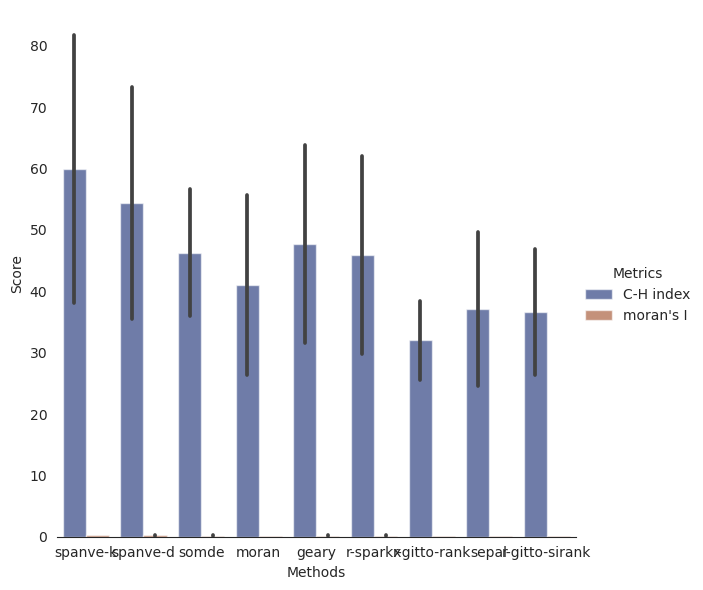

In [41]:
dfvis = pd.DataFrame(
    np.concatenate([df_metrics[['soft','s1']],df_metrics[['soft','s2']]],axis=0),
    columns = ['Methods','Score']
)
dfvis['Metrics'] = ['C-H index' for i in range(dfvis.shape[0]//2)] + ['moran\'s I' for i in range(dfvis.shape[0]//2)]


sns.set_style(style='white')
g = sns.catplot(
    data=dfvis, kind="bar",
    x="Methods", y="Score", hue="Metrics",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
# g.legend.set_title("")